# BUILDING A PERSONALIZED MOVIE RECOMMENDATION SYSTEM
---
COLLABORATIVE AND CONTENT-BASED FILTERING

## BUSINESS PROBLEM:
---


In today's digital world, users are overwhelmed with vast amounts of content, whether it's movies, products, music, or news articles. Businesses struggle to keep users engaged by providing personalized recommendations. Without an effective recommender system, customers may churn, engagement may decline, and businesses may lose revenue opportunities.


For example, in an online movie streaming platform, users need relevant and personalized movie recommendations based on their viewing history and preferences. A poor recommendation system may result in users struggling to find interesting content, leading to lower customer satisfaction and reduced subscription retention.

## OBJECTIVES
---


By implementing an effective recommender system, businesses can:

1. Increase user engagement and retention.

2. Improve customer satisfaction by offering relevant recommendations.

3. Enhance revenue opportunities through personalized marketing.



## GOALS
---

The goal of this study is to develop a personalized recommendation system that improves user experience and engagement by suggesting relevant content based on past interactions. This will be achieved using:

1. Collaborative Filtering: Predict user preferences based on similar users.

2. Content-Based Filtering: Recommend items similar to what a user has liked before.

3. Hybrid Approach (Optional): Combine multiple recommendation techniques for better accuracy.

4. Performance Evaluation: Assess the effectiveness of different models using evaluation metrics such as RMSE (Root Mean Squared Error) and Cosine Similarity

## IMPORTING THE NECCESSRY LIBRARIES
---

*  Import necessary libraries for data handling, visualization, and modeling.



In [5]:
!pip install surprise

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from surprise.prediction_algorithms import knns
from surprise import Reader, Dataset, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## LOADING THE DATASET
---
*   Read and explore the dataset.


In [3]:
# upload links datasets
links = pd.read_csv("links.csv")
print(links.shape)
# links.head(5)

#upload movies dataset
movies = pd.read_csv("movies.csv")
print(movies.shape)
# movies.head(5)

# upload ratings dataset
ratings = pd.read_csv("ratings.csv")
print(ratings.shape)
#ratings.head(5)


(9742, 3)
(9742, 3)
(100836, 4)


(9742, 23)

## DATA CLEANING

*   Merging the Datasets
*   Drop the irrelevant columns
*   Handle missing data.
*   Remove duplicate records, if any.
*   Clean or transform data types as necessary.

In [5]:
# Merge links and movies dataset using 'movieId'
links_movies = pd.merge(links, movies, on="movieId", how="inner")

# Now merge the result with ratings using 'movieId'
links_movies_ratings = pd.merge(links_movies, ratings, on="movieId", how="inner")

# Print shapes and display the first few rows
print(links_movies_ratings.shape)

# view the dataset
links_movies_ratings.head(5)

(100836, 8)


,movieId,imdbId,tmdbId,title,genres,userId,rating,timestamp
0,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [7]:
# drop columns
links_movies_ratings.drop(["imdbId", "tmdbId", "timestamp"], axis=1, inplace=True)
links_movies_ratings.head(5)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [6]:
# handle missing value
links_movies_ratings.dropna(inplace=True)
links_movies_ratings.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,0
title,0
genres,0
userId,0
rating,0
timestamp,0


In [10]:
# Standardizing User ID & Movie ID for better numerical stability
scaler = StandardScaler()

# Apply StandardScaler to userId and movieId
ratings[['userId', 'movieId']] = scaler.fit_transform(ratings[['userId', 'movieId']])

# Convert back to integers after scaling
ratings[['userId', 'movieId']] = ratings[['userId', 'movieId']].astype(int)

## DATA PREPROSSESSING

In [13]:
# Data Preprocessing Pipeline
def preprocess_movies(movies_df):
    movies_df['genres'] = movies['genres'].str.replace('|', ' ')
    vectorizer = TfidfVectorizer(stop_words='english')
    genre_matrix = vectorizer.fit_transform(movies_df['genres'])
    return genre_matrix

movies_tfidf_matrix = preprocess_movies(movies)
movies_tfidf_matrix.shape

(9742, 23)

## EXPLORATORY DATA ANALYSIS (EDA)

*   Basic statistics.
*   Data visualization.



###  1.Rating

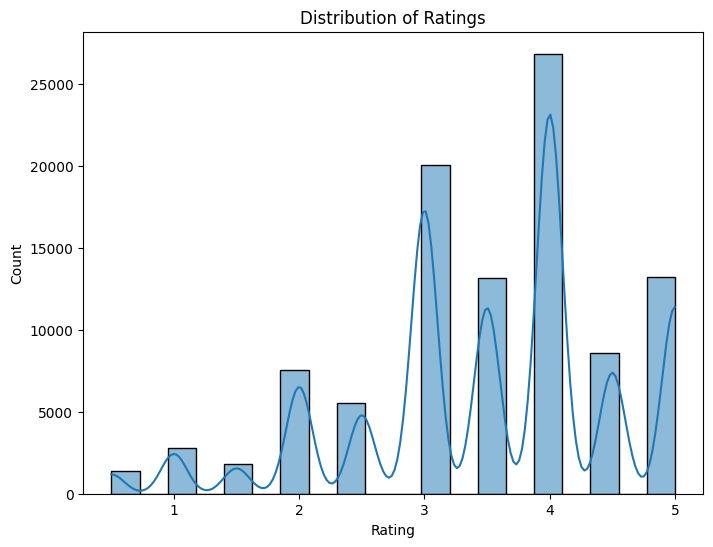

In [11]:
# EDA for rating: plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(links_movies_ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**EXPLANATION**

> The Histogram shows that majority of the movies are rated 4 while very few had a rating of 1.


> The distribution is skewed towards higher ratings, with the highest frequency at Rating 4.

> As the ratings increase from 1 to 5, the number of counts increases too, showing that more movies received higher ratings.


> This pattern suggests that, in this dataset, movies are more likely to receive higher ratings than lower ones.














### 2.Genre:

Genre counts:
       genre  count
0      Drama  41926
1     Comedy  39050
2     Action  30635
3   Thriller  26448
4  Adventure  24157


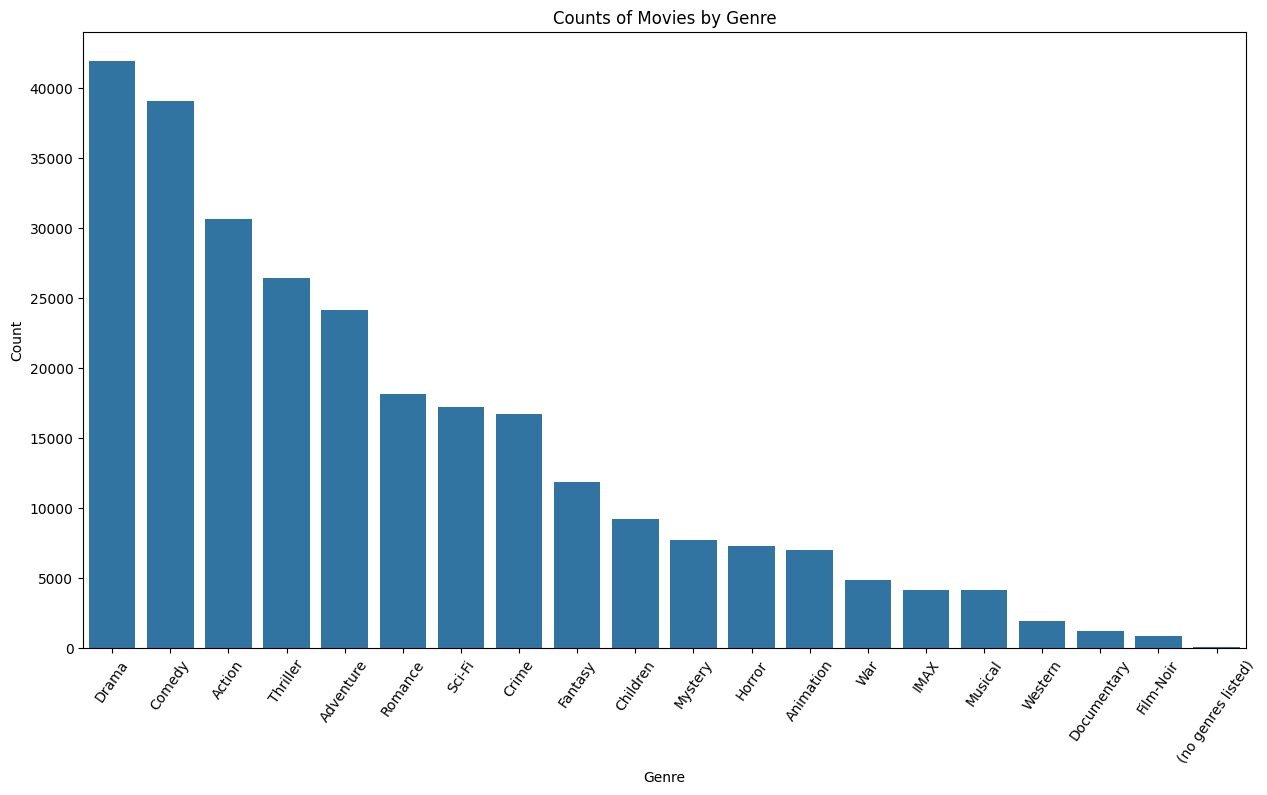

In [12]:
# Each movie can have multiple genres separated by '|'. We need to split them.

# Create a copy of the dataframe to explode genres
df_genre = links_movies_ratings.copy()
# Replace '(no genres listed)' with NaN maybe
# Split genres by '|'
df_genre['genres'] = df_genre['genres'].fillna('')
df_genre = df_genre.assign(genre = df_genre['genres'].str.split('\|'))

# Explode to have one genre per row
df_exploded = df_genre.explode('genre')

# Count per genre overall
genre_counts = df_exploded['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']
print('Genre counts:')
print(genre_counts.head(5))

# Plot genre counts
plt.figure(figsize=(15, 8))
sns.barplot(data=genre_counts, x='genre', y='count')
plt.title('Counts of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=55)
plt.show()

**EXPLANATION**

> Drama is the most frequent genre, with over 40,000 movies. It is followed closely by Comedy and Action, which also have large counts. Genres such as Thriller, Adventure, and Romance appear in the middle range, with counts significantly lower than Drama but still in the high teens to low 20,000s



> On the other end of the spectrum, genres like Western, Documentary, and Film-Noir are much less frequent, with counts well under 5,000.




### 3.Rating by Title

In [14]:
# Rating group by title
avg_rating_title = links_movies_ratings.groupby('title')['rating'].mean().reset_index()
avg_rating_title = avg_rating_title.sort_values('rating', ascending=False)
print('Average rating per title:')
print(avg_rating_title.head(20))
# consider count

Average rating per title:
                                                  title  rating
3352                          Gena the Crocodile (1969)     5.0
214                          Act of Killing, The (2012)     5.0
4136                           Hunting Elephants (2013)     5.0
6429                                 Palindromes (2004)     5.0
858   Battle Royale 2: Requiem (Batoru rowaiaru II: ...     5.0
2522         Dr. Goldfoot and the Bikini Machine (1965)     5.0
5585                                    Mephisto (1981)     5.0
6765                                      Presto (2008)     5.0
3164  Four Days in September (O Que É Isso, Companhe...     5.0
2508                          Down Argentine Way (1940)     5.0
4152                                       Hype! (1996)     5.0
3169                           Four Seasons, The (1981)     5.0
8392  The Adventures of Sherlock Holmes and Doctor W...     5.0
5542                                    Meantime (1984)     5.0
8393  The Adve

### 4.Rating per Genre

In [1]:
# calculate average rating per genre
avg_rating_genre = df_exploded.groupby('genre')['rating'].mean().reset_index()
avg_rating_genre = avg_rating_genre.sort_values('rating', ascending=False)
print('Average rating per genre:')
print(avg_rating_genre)

NameError: name 'df_exploded' is not defined

### 5.Correlation Analysis

In [ ]:
# Create a user-item matrix and compute correlation between movies
user_item_matrix = links_movies_ratings.pivot(index='userId', columns='movieId', values='rating')

# Compute correlation matrix for movies (columns correlation)
movie_corr = user_item_matrix.corr()

# print('Correlation matrix for movies:')
# print(movie_corr)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(movie_corr, annot=True, cmap='Blues', center=0)
plt.title('Correlation Matrix of Movies based on User Ratings')
plt.show()

# # Save the correlation matrix to CSV file
# movie_corr.to_csv('movie_correlation_matrix.csv')

### Preparing the data for Surprise

In [ ]:
# Define the rating scale from the min to the max
links_movies_ratings["rating"].min() # =0.5
links_movies_ratings["rating"].max() # = 5.0
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data from the pandas dataframe into a Surprise Dataset
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# To further inspect the built dataset, you could build the full trainset
trainset = data.build_full_trainset()
print("Number of users: " + str(trainset.n_users))
print("Number of items: " + str(trainset.n_items))


### Split and Train the data

In [ ]:
# Define the rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Load data into Surprise Dataset
data = Dataset.load_from_df(links_movies_ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset into training and testing set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

Training a basic SVD model

In [ ]:
# Train a basic SVD model on the training set
algo = SVD(random_state=42)
algo.fit(trainset)

# Predict on the testset
predictions = algo.test(testset)

# Compute and print RMSE
rmse = accuracy.rmse(predictions)

print('RMSE on test set:', rmse)
print('Number of predictions:', len(predictions))

### Collaborative based filtering - Using Item Base

#### Configure the model

In [ ]:
# Define similarity options
sim_options = {
    'name': 'cosine',  # Use cosine similarity to measure the similarity between items
    'user_based': False  # Set to False for item-based filtering (True would be for user-based filtering)
}

# Build the model using the KNNBasic algorithm
item_cf_model = KNNBasic(sim_options=sim_options)

# Train the model on the training set
item_cf_model.fit(trainset)

NameError: name 'KNNBasic' is not defined

In [ ]:
sim_cosine = {"name": "cosine", "user_based": False}
basic_cosine = knns.KNNBasic(sim_options=sim_cosine)
basic_cosine.fit(trainset)
predictions = basic_cosine.test(testset)
print(accuracy.rmse(predictions))

#### TRaining the model

In [ ]:
# Define movie titles
movie_title_1 = "Avenger"
movie_title_2 = "Ex Drummer"

# Find the movie IDs for the given titles from the combined DataFrame
movie_id_1 =links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_1, case=False, na=False)]['movieId'].values
movie_id_2 = links_movies_ratings[links_movies_ratings['title'].str.contains(movie_title_2, case=False, na=False)]['movieId'].values

# Check if the movie titles were found
if len(movie_id_1) > 0:
    rating_1 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_1[0]]['rating'].values[0]
    print(f"Movie: {movie_title_1}, Rating: {rating_1}")
else:
    print(f"Movie '{movie_title_1}' not found.")

if len(movie_id_2) > 0:
    rating_2 = links_movies_ratings[links_movies_ratings['movieId'] == movie_id_2[0]]['rating'].values[0]
    print(f"Movie: {movie_title_2}, Rating: {rating_2}")
else:
    print(f"Movie '{movie_title_2}' not found.")


###  Making Recommendations Based on a Movie Title**

In [ ]:
def get_similar_movies(movie_title, model, trainset, movies_df, top_n=5):
    # Find the movie ID for the given title
    movie_id = movies_df[movies_df['title'].str.contains(movie_title, case=False, na=False)]['movieId'].values

    # Convert the movieId to an internal ID used by Surprise (trainset)
    movie_inner_id = trainset.to_inner_iid(movie_id[0])

    # Get the top N most similar movies using the KNN model's get_neighbors function
    neighbors = model.get_neighbors(movie_inner_id, k=top_n)

    # Map internal IDs back to movie titles
    similar_titles = [(movies_df[movies_df['movieId'] == int(trainset.to_raw_iid(neighbor))]['title'].values[0])
                      for neighbor in neighbors]

    return similar_titles

In [ ]:
# Movie title input
movie_title = "Shooter"

# Get the top 5 similar movies
recommended_movies = get_similar_movies(movie_title, item_cf_model, trainset, links_movies_ratings, top_n=5)

# Print the recommended movies (only titles)
if isinstance(recommended_movies, list):
    print(f"Top 5 similar movies to '{movie_title}':")
    for movie in recommended_movies:
        print(movie)
else:
    print(recommended_movies)